<a href="https://colab.research.google.com/github/Ayush-ui309/Ayush/blob/master/CSAO_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Preview:


,user_id,restaurant_id,city,cart_item,recommended_item,time_of_day,cart_size,order_value,user_loyalty_score,previous_accept_rate,is_peak_hour,new_user_flag,new_restaurant_flag,accepted
0,861,338,Mumbai,Sandwich,Coke,Night,4,444.312779,0.712692,0.331464,1,0,0,1
1,1295,171,Mumbai,Burger,Coke,Night,3,734.605483,0.284175,0.187918,1,0,0,0
2,1131,67,Chennai,Sandwich,GulabJamun,Night,2,276.967107,0.838026,0.184485,1,0,0,0
3,1096,625,Chennai,Pizza,IceCream,Night,3,272.800003,0.779312,0.870970,1,0,0,1
4,1639,300,Delhi,Pizza,IceCream,Night,1,334.350051,0.119877,0.859821,1,0,0,0



Class Distribution:
accepted
1    6318
0    2682
Name: count, dtype: int64

Best Parameters: {'max_depth': 12, 'min_samples_split': 4, 'n_estimators': 350}

Accuracy: 0.7205555555555555

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       527
           1       0.81      0.79      0.80      1273

    accuracy                           0.72      1800
   macro avg       0.66      0.67      0.67      1800
weighted avg       0.72      0.72      0.72      1800


Cross-Validated AUC: 0.7570126851816291


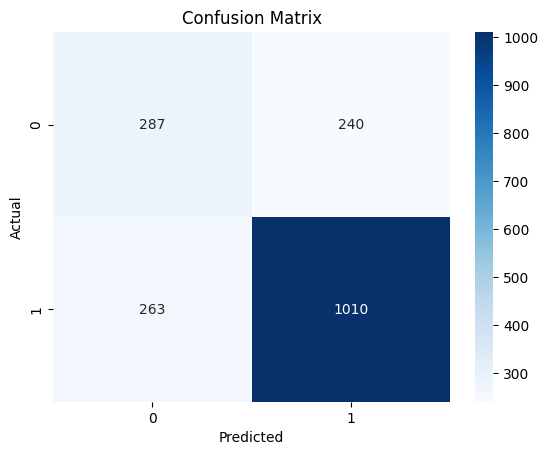

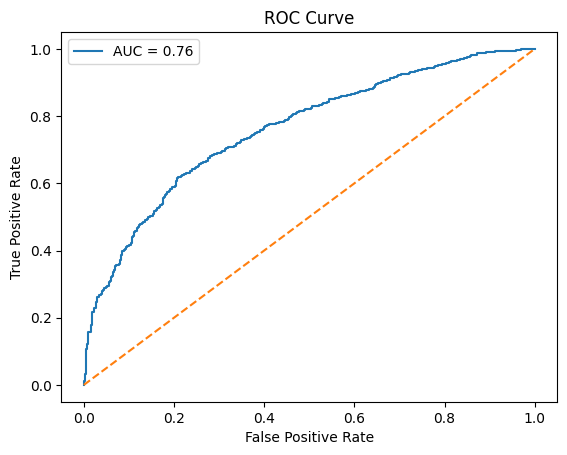

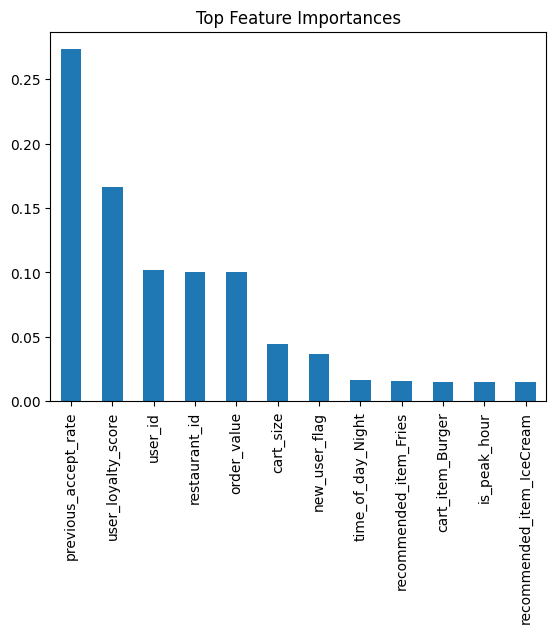


Sample Prediction:
Predicted Acceptance: 1
Probability of Acceptance: 0.7756295205979219


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

np.random.seed(42)

n_samples = 9000

cities = ["Mumbai", "Delhi", "Bangalore", "Chennai"]
cart_items = ["Burger", "Pizza", "Sandwich", "Biryani"]
recommended_items = ["Coke", "Fries", "IceCream", "GulabJamun"]
time_of_day = ["Morning", "Afternoon", "Night"]

data = pd.DataFrame({
    "user_id": np.random.randint(1, 2500, n_samples),
    "restaurant_id": np.random.randint(1, 800, n_samples),
    "city": np.random.choice(cities, n_samples),
    "cart_item": np.random.choice(cart_items, n_samples),
    "recommended_item": np.random.choice(recommended_items, n_samples),
    "time_of_day": np.random.choice(time_of_day, n_samples),
    "cart_size": np.random.randint(1, 6, n_samples),
    "order_value": np.random.normal(400, 120, n_samples).clip(150, 1200),
    "user_loyalty_score": np.random.uniform(0, 1, n_samples),
    "previous_accept_rate": np.random.uniform(0, 1, n_samples)
})

data["is_peak_hour"] = data["time_of_day"].apply(lambda x: 1 if x == "Night" else 0)
data["new_user_flag"] = data["previous_accept_rate"].apply(lambda x: 1 if x < 0.15 else 0)
data["new_restaurant_flag"] = np.random.choice([0, 1], n_samples, p=[0.85, 0.15])

def generate_acceptance(row):
    score = 0.15
    if row["cart_item"] == "Burger" and row["recommended_item"] == "Fries":
        score += 0.40
    if row["cart_item"] == "Pizza" and row["recommended_item"] == "Coke":
        score += 0.35
    if row["cart_item"] == "Biryani" and row["recommended_item"] == "GulabJamun":
        score += 0.30
    if row["city"] == "Mumbai" and row["recommended_item"] == "Coke":
        score += 0.10
    if row["is_peak_hour"] == 1:
        score += 0.15
    if row["cart_size"] >= 4:
        score -= 0.10
    score += 0.65 * row["previous_accept_rate"]
    score += 0.35 * row["user_loyalty_score"]
    return 1 if np.random.rand() < min(score, 0.97) else 0

data["accepted"] = data.apply(generate_acceptance, axis=1)

print("Dataset Preview:")
display(data.head())

print("\nClass Distribution:")
print(data["accepted"].value_counts())

data_encoded = pd.get_dummies(
    data,
    columns=["city", "cart_item", "recommended_item", "time_of_day"],
    drop_first=True
)

X = data_encoded.drop("accepted", axis=1)
y = data_encoded["accepted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestClassifier(random_state=42, class_weight="balanced")

param_grid = {
    "n_estimators": [250, 350],
    "max_depth": [12, 18],
    "min_samples_split": [2, 4]
}

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

print("\nBest Parameters:", grid_search.best_params_)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(model, X, y, cv=5, scoring="roc_auc")
print("\nCross-Validated AUC:", cv_scores.mean())

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).head(12).plot(kind="bar")
plt.title("Top Feature Importances")
plt.show()

sample = X_test.iloc[0:1]
prediction = model.predict(sample)[0]
probability = model.predict_proba(sample)[0][1]

print("\nSample Prediction:")
print("Predicted Acceptance:", prediction)
print("Probability of Acceptance:", probability)